# 데이터 분석

In [1]:
import pandas as pd
import numpy as np
from datetime import date
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.font_manager as fm
from matplotlib import gridspec

In [2]:
path = '../9.데이터/0.작업 데이터/0.전처리 데이터/'
path_3d = '../9.데이터/0.작업 데이터/9.3D 그래프/'
path_h = "../9.데이터/0.작업 데이터/2.사고 데이터/0.히트맵/"

In [3]:
## v1 버전이 속도 0인데 교통량 존재하는 데이터들 삭제한 데이터

up_data_v1 = pd.read_csv(path + 'upline_data_v1.csv', encoding='utf-8')
down_data_v1 = pd.read_csv(path + 'downline_data_v1.csv', encoding='utf-8')

In [4]:
up_data_v1["datetime"] = up_data_v1["통계날짜"] + " " + up_data_v1["통계시각"]
up_data_v1["datetime"] = pd.to_datetime(up_data_v1["datetime"], format='%Y-%m-%d %H:%M:%S', errors='raise')
up_data_v1["요일"] = up_data_v1["datetime"].dt.weekday

down_data_v1["datetime"] = down_data_v1["통계날짜"] + " " + down_data_v1["통계시각"]
down_data_v1["datetime"] = pd.to_datetime(down_data_v1["datetime"], format='%Y-%m-%d %H:%M:%S', errors='raise')
down_data_v1["요일"] = down_data_v1["datetime"].dt.weekday

## 3D 그래프, 등고선 그래프 생성

In [5]:
##  평일, 주말별 평균 속도 및 교통량 피벗 테이블 생성
####  속도 교통량을 함께 가지는 피벗테이블을 만드는 코드
####  평일 주말로 나누어서 피벗테이블 생성

## dataset : 피벗스타일로 만들 데이터셋 입력
## values : "속도", "교통량" 중 선택

def to_pivot_mean_data(dataset, values):
    dataset["차로"] = 1
    line1_data = dataset.copy()

    dataset["차로"] = 2
    line2_data = dataset.copy()

    dataset["차로"] = 3
    line3_data = dataset.copy()

    dataset["차로"] = 4
    line4_data = dataset.copy()

    line1_data = line1_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "1차로 교통량", "1차로 속도"]]
    line1_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line2_data = line2_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "2차로 교통량", "2차로 속도"]]
    line2_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line3_data = line3_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "3차로 교통량", "3차로 속도"]]
    line3_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line4_data = line4_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "4차로 교통량", "4차로 속도"]]
    line4_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]

    total_line= pd.concat([line1_data, line2_data, line3_data, line4_data])
    
    weekday_total = total_line.loc[total_line["요일"] <= 4]
    weekend_total = total_line.loc[total_line["요일"] > 4]
    
    pivot_weekday = pd.pivot_table(weekday_total, index=["통계시각"], columns= ["차로", "레이더ID"], values = values, aggfunc = 'mean')
    pivot_weekend = pd.pivot_table(weekend_total, index=["통계시각"], columns= ["차로", "레이더ID"], values = values, aggfunc = 'mean')
    
    return pivot_weekday, pivot_weekend

In [6]:
##   3D 그래프와 등고선을 생성하는 함수
#### 차선별, 요일별 시간-레이더 3D 그래프와 등고선 그래프를 생성

## dataset : 피벗스타일로 만들 데이터셋 입력
## line : 생성할 라인 입력
## values : "속도", "교통량" 중 선택

def create_3D_Graph(dataset, line, values):
    pivot_weekday, pivot_weekend = to_pivot_mean_data(dataset, values)
    pivot_list = [pivot_weekday, pivot_weekend]
    
    for i_list in pivot_list:
        
        x = range(288)
        y = range(int(i_list.shape[1]/4))
        Z = i_list[line].T.to_numpy()       

        X, Y = np.meshgrid(x, y)

        ## 3D 그래프 생성
        
        fig = plt.figure(1, figsize = (8, 8))
        ax = fig.add_subplot(111, projection = '3d')

        ax.set_title("시간-레이더 3D {} 그래프 ({}차로)".format(values, line), fontsize=12)

        ax.set_xlabel("Time")
        ax.set_xticks([0, 23, 47, 71, 95, 119, 143, 167, 191, 215, 239, 263, 287], minor=False)
        ax.set_xticklabels(["0","2","4","6","8","10","12","14","16","18","20","22","24"])

        ax.set_ylabel("RADR")
        ax.set_yticks(list(range(int(i_list.shape[1]/4))))
        ax.set_yticklabels(list(range(1, int(i_list.shape[1]/4)+1)))

        ax.set_zlabel("{}".format(values))

        if values == "속도":
            ax.set_zlim(0, 110)
        else:
            ax.set_zlim(0, 170)

        surface = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0.1)
        plt.show()
        
        
        ## 등고선 그래프 생성
        
        fig1, ax1 = plt.subplots()    

        ax1.set_title("시간-레이더 등고선 {} 그래프 ({}차로)".format(values, line), fontsize=12)
        
        ax1.set_xlabel("Time")
        ax1.set_xticks([0, 23, 47, 71, 95, 119, 143, 167, 191, 215, 239, 263, 287], minor=False)
        ax1.set_xticklabels(["0","2","4","6","8","10","12","14","16","18","20","22","24"])

        ax1.set_ylabel("RADR")
        ax1.set_yticks(list(range(int(i_list.shape[1]/4))))
        ax1.set_yticklabels(list(range(1, int(i_list.shape[1]/4)+1)))

        contour = ax1.contourf(X, Y, Z, cmap=matplotlib.cm.coolwarm)
        plt.colorbar(contour)
        plt.show()

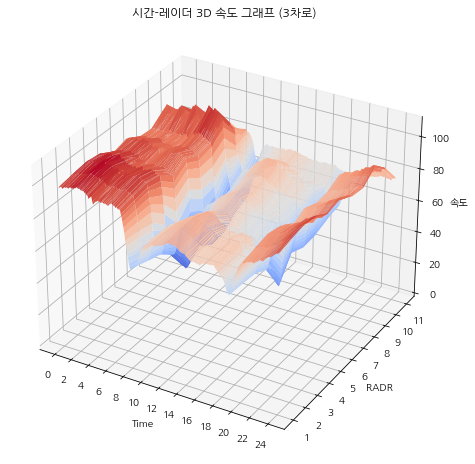

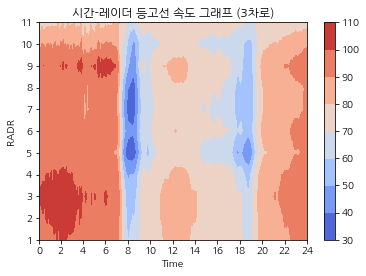

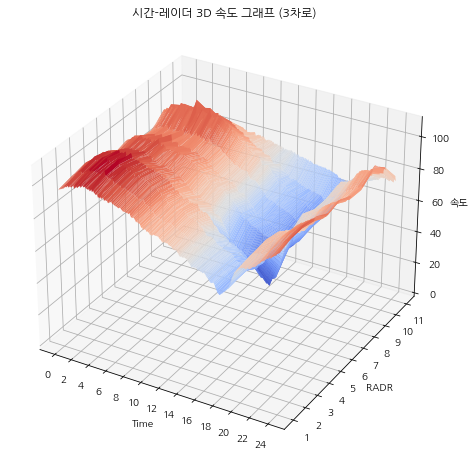

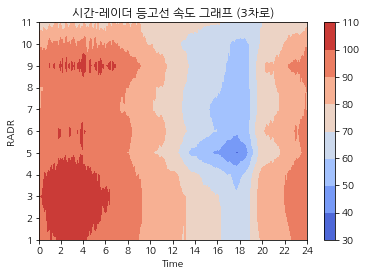

In [8]:
create_3D_Graph(up_data_v1, 3, "속도")

## 사고데이터 분류 및 생성

In [7]:
##  각 날짜 별로 피벗 테이블 생성

def to_pivot_each_data(dataset, values):
    dataset["차로"] = 1
    line1_data = dataset.copy()

    dataset["차로"] = 2
    line2_data = dataset.copy()

    dataset["차로"] = 3
    line3_data = dataset.copy()

    dataset["차로"] = 4
    line4_data = dataset.copy()

    line1_data = line1_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "1차로 교통량", "1차로 속도"]]
    line1_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line2_data = line2_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "2차로 교통량", "2차로 속도"]]
    line2_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line3_data = line3_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "3차로 교통량", "3차로 속도"]]
    line3_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]
    line4_data = line4_data[["통계날짜", "통계시각", "레이더ID", "차로", "요일", "4차로 교통량", "4차로 속도"]]
    line4_data.columns = ["통계날짜", "통계시각", "레이더ID", "차로", "요일", "교통량", "속도"]

    total_line= pd.concat([line1_data, line2_data, line3_data, line4_data])
    
    weekday_total = total_line.loc[total_line["요일"] <= 4]
    weekend_total = total_line.loc[total_line["요일"] > 4]
    
    weekday_date = weekday_total["통계날짜"].unique()
    weekend_date = weekend_total["통계날짜"].unique()
    
    pivot_weekday = pd.pivot_table(weekday_total, index=["통계날짜", "통계시각"], columns= ["차로", "레이더ID"], values = values)
    pivot_weekend = pd.pivot_table(weekend_total, index=["통계날짜", "통계시각"], columns= ["차로", "레이더ID"], values = values)
    
    return pivot_weekday, pivot_weekend, weekday_date, weekend_date

In [10]:
test = to_pivot_mean_data(up_data_v1, "속도")

In [14]:
RADR_list = up_data_v1["레이더ID"].unique()
    
plt.rcParams['figure.figsize'] = [12, 7]
    
pivot_weekday, pivot_weekend = to_pivot_mean_data(up_data_v1, "속도")
pivot_weekday_TEST, pivot_weekend_TEST, weekday_date, weekend_date = to_pivot_each_data(up_data_v1, "속도")

pivot_list = [pivot_weekday, pivot_weekend]
num = 0

In [23]:
pivot_list[1]

차로                1                                                         \
레이더ID        RADR11     RADR12     RADR13     RADR14     RADR15     RADR16   
통계시각                                                                         
00:00:00  90.717277  92.720430  94.005435  93.025510  90.994444  89.302703   
00:05:00  91.668394  93.703704  95.229947  93.580000  91.605405  89.767196   
00:10:00  91.836842  93.621622  95.203297  93.676768  91.739130  89.946524   
00:15:00  91.720207  93.920635  95.545455  93.562814  91.527174  89.918919   
00:20:00  91.968750  94.021277  95.322581  94.404040  92.081522  90.574468   
...             ...        ...        ...        ...        ...        ...   
23:35:00  89.367021  91.815217  93.274725  92.256410  90.342541  88.197802   
23:40:00  90.913043  93.077778  93.655556  92.568528  91.000000  89.145251   
23:45:00  91.390374  93.502762  94.961538  93.549223  91.717514  90.062500   
23:50:00  91.378378  93.589888  94.927374  94.078534  92.240223  90.685083   
23:55:00  92.225806  94.324176  95.584270  94.622340  92.068182  90.612717   

차로                                                    ...          4  \
레이더ID        RADR17     RADR18     RADR19     RADR20  ...     RADR12   
통계시각                                                  ...              
00:00:00  86.074866  83.918660  90.390476  87.476190  ...  95.827957   
00:05:00  86.026455  84.558252  90.990566  88.261682  ...  95.444444   
00:10:00  86.389474  84.863415  91.733333  88.247619  ...  98.135135   
00:15:00  86.559585  84.620853  91.028302  87.388350  ...  97.328042   
00:20:00  86.431579  84.545455  91.306931  88.346154  ...  96.494681   
...             ...        ...        ...        ...  ...        ...   
23:35:00  85.577540  84.198068  90.107843  87.250000  ...  95.831522   
23:40:00  85.628415  84.090452  91.128713  88.292929  ...  96.633333   
23:45:00  86.895028  84.979798  91.979592  88.469388  ...  96.657459   
23:50:00  87.060109  85.248731  91.979381  89.247525  ...  96.320225   
23:55:00  86.972527  85.436842  92.533333  89.484211  ...  95.219780   

차로                                                                          \
레이더ID        RADR13     RADR14     RADR15     RADR16     RADR17     RADR18   
통계시각                                                                         
00:00:00  95.277174  94.566327  97.555556  91.054054  86.620321  83.540670   
00:05:00  95.636364  92.365000  96.578378  88.978836  84.396825  82.466019   
00:10:00  97.884615  94.818182  99.320652  91.812834  86.842105  84.370732   
00:15:00  97.374332  95.000000  96.847826  91.070270  86.124352  83.274882   
00:20:00  96.064516  92.883838  97.869565  89.063830  86.363158  82.598086   
...             ...        ...        ...        ...        ...        ...   
23:35:00  96.269231  93.871795  96.591160  90.071429  85.818182  82.463768   
23:40:00  94.655556  92.593909  96.773481  90.743017  86.650273  83.773869   
23:45:00  95.115385  92.896373  95.508475  90.414773  87.618785  84.055556   
23:50:00  95.039106  94.926702  98.770950  91.983425  84.797814  82.142132   
23:55:00  94.691011  95.755319  97.590909  92.849711  88.516484  84.173684   

차로                                         
레이더ID        RADR19     RADR20     RADR21  
통계시각                                       
00:00:00  84.476190  81.133333  75.158416  
00:05:00  85.952830  83.093458  78.484536  
00:10:00  87.266667  83.638095  77.446809  
00:15:00  85.754717  83.233010  77.222222  
00:20:00  86.188119  83.557692  76.980000  
...             ...        ...        ...  
23:35:00  85.147059  82.875000  76.561224  
23:40:00  85.178218  83.343434  76.608696  
23:45:00  86.612245  83.224490  76.402174  
23:50:00  84.484536  82.920792  76.915789  
23:55:00  86.577778  84.378947  78.523810  

[288 rows x 44 columns]

In [16]:
##  사고로 판단되는 데이터 리스트 및 날짜 리턴, 히트맵 출력 함수
#### 사고라고 판단되는 데이터의 리스트와 해당날짜를 리턴하고, 해당 데이터의 히트맵과 패턴데이터의 히트맵을 출력하는 함수
#### 사고판단기준 : 속도 감소율이 30% 이상이며, 이 감소율이 30분 이상 지속되고, 그 영향이 하류부로 퍼질때 사고로 판단
#### 코드의 한계 : 코드에서 사고로 출력기준은 패턴에 비해 30% 감소한 레이더가 6시퀀트 이상 있을때 사고로 판단
####               1)지속기준으로 바꾸어 줘야함 2) 하류부로 전파가 되어야함

def create_accident_list(dataset, values):
    
    RADR_list = dataset["레이더ID"].unique()
    
    plt.rcParams['figure.figsize'] = [12, 7]
    
    pivot_weekday, pivot_weekend = to_pivot_mean_data(dataset, values)
    pivot_weekday_TEST, pivot_weekend_TEST, weekday_date, weekend_date = to_pivot_each_data(dataset, values)

    pivot_list = [pivot_weekday, pivot_weekend]
    num = 0
    
    for p_it in pivot_list:
        if num == 0:
            c_it = pivot_weekday_TEST
            date_list = weekday_date
        else:
            c_it = pivot_weekend_TEST
            date_list = weekend_date
        
        num += 1
        
        accident_list = []
        accident_list_name = []
        accident_num = 0
        
        for itm in date_list:

            each_date = c_it.loc[itm]
            test = (p_it - each_date) - (p_it * 0.3)
            test = test.reset_index()

            for i in range(1, 5):

                for j in RADR_list:

                    if len(test.loc[test[i, j]>0][i, j]) > 6:

                        index_list = test.loc[test[i, j]>0][i, j].index
                        radr_num = len(RADR_list)
                        
                        if i == 1:
                            accident = each_date.iloc[(index_list[0] - 25):(index_list[0] +25), :radr_num]
                        elif i == 2:
                            accident = each_date.iloc[(index_list[0] - 25):(index_list[0] +25), radr_num:radr_num*2]
                        elif i == 3:
                            accident = each_date.iloc[(index_list[0] - 25):(index_list[0] +25), radr_num*2:radr_num*3]
                        else:
                            accident = each_date.iloc[(index_list[0] - 25):(index_list[0] +25), radr_num*3:]   
                        try:
                            pattern = p_it.loc[accident.index[0]:accident.index[49]][i]
                        except: continue
                        
                        fig = plt.figure(figsize=(21, 5)) 
                        gs = gridspec.GridSpec(1, 2)

                        plt.subplot(gs[0])
                        sns.heatmap(accident, yticklabels = radr_num, vmin=0, vmax=100)
                        plt.title("{} {}차선 {} - accident#{}".format(itm, i, j,accident_num), fontsize=15)
                        plt.subplot(gs[1])
                        sns.heatmap(pattern, yticklabels = radr_num, vmin=0, vmax=100)
                        plt.title("{} {}차선 {} - Pattern".format(itm, i, j), fontsize=15)

                        fig.savefig(path_h + "{} {}차선 {} - accident#{}".format(itm, i, j,accident_num) + ".jpg", dpi=400)
                        plt.cla()
                        plt.close(fig)
                        
                        accident_list.append(accident)
                        accident_list_name.append(itm)

                        accident_num += 1

                    break

            
    return accident_list, accident_list_name

In [ ]:
accident_list, accident_list_name = create_accident_list(up_data_v1, "속도")

In [ ]:
down_accident_list, down_accident_list_name = create_accident_list(down_data_v1, "속도")

In [731]:
####  사고라고 판단된 일수 출력

accident_unique = set(accident_list_name)
print(len(accident_unique))

down_accident_unique = set(down_accident_list_name)
print(len(down_accident_unique))

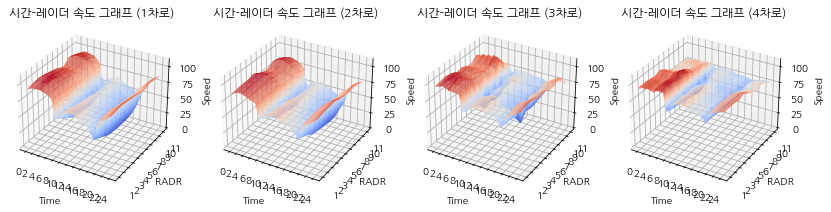

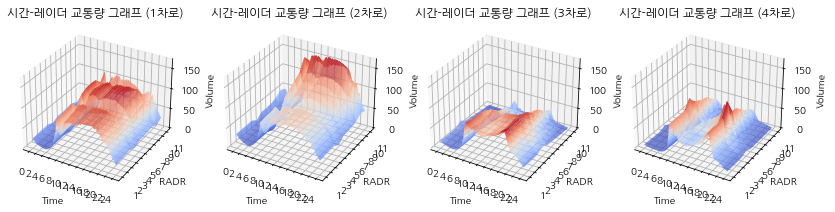

In [56]:
##  object oriented API 방식

x = range(288)
y = range(11)

X, Y = np.meshgrid(x, y)


fig1 = plt.figure(1, figsize = (14, 15))

for i in range(1,5):
    
    Z = up_speed[i].T.to_numpy()
    
    ax1 = fig1.add_subplot(1, 4, i, projection = '3d')
    
    ax1.set_title("시간-레이더 속도 그래프 ({}차로)".format(i), fontsize=12)
        
    ax1.set_xlabel("Time")
    ax1.set_xticks([0, 23, 47, 71, 95, 119, 143, 167, 191, 215, 239, 263, 287], minor=False)
    ax1.set_xticklabels(["0","2","4","6","8","10","12","14","16","18","20","22","24"])

    ax1.set_ylabel("RADR")
    ax1.set_yticks(list(range(11)))
    ax1.set_yticklabels(list(range(1, 12)))

    ax1.set_zlabel("Speed")
    ax1.set_zlim(0, 110)

    surface = ax1.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0.1)

fig2 = plt.figure(2, figsize = (14, 15))


for i in range(1,5):
    
    Z = up_volume[i].T.to_numpy()
    
    ax2 = fig2.add_subplot(1, 4, i, projection = '3d')

    ax2.set_title("시간-레이더 교통량 그래프 ({}차로)".format(i), fontsize=12)
        
    ax2.set_xlabel("Time")
    ax2.set_xticks([0, 23, 47, 71, 95, 119, 143, 167, 191, 215, 239, 263, 287], minor=False)
    ax2.set_xticklabels(["0","2","4","6","8","10","12","14","16","18","20","22","24"])

    ax2.set_ylabel("RADR")
    ax2.set_yticks(list(range(11)))
    ax2.set_yticklabels(list(range(1, 12)))

    ax2.set_zlabel("Volume")
    ax2.set_zlim(0, 170)

    surface = ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, linewidth=0.1)    

plt.show()